In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras import Sequential
from keras.layers import LSTM, Dense,Conv1D

In [2]:
data_list=[]
for i in range(5):
    data = pd.read_csv('/kaggle/input/traffic-prediction-data/d11_text_station_5min_2019_09_0'+str(i+1)+'.csv',header=None)
    data = data.iloc[:,[0,1,9]]
    data.columns=['time','station_num','flow']
    if len(data_list) == 0:
        data_list.append(data)
    else:
        data_list[0] = pd.concat([data_list[0],data],ignore_index=True)
data=data_list[0]
data

,time,station_num,flow
0,09/01/2019 00:00:00,1100313,NaN
1,09/01/2019 00:00:00,1100323,NaN
2,09/01/2019 00:00:00,1100326,14.0
3,09/01/2019 00:00:00,1100330,5.0
4,09/01/2019 00:00:00,1100333,NaN
...,...,...,...
2149915,09/05/2019 23:55:00,1127007,7.0
2149916,09/05/2019 23:55:00,1127014,3.0
2149917,09/05/2019 23:55:00,1127026,107.0
2149918,09/05/2019 23:55:00,1127030,22.0


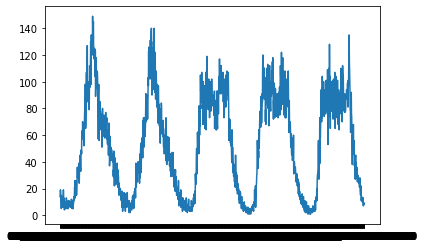

In [3]:
data_1100326 = data.loc[data['station_num']==1100326].dropna(subset=['flow'])
plt.plot(data_1100326['time'],data_1100326['flow'])

In [4]:
data=data.groupby('station_num').filter(lambda x : x.flow.count()!=0)
data.fillna(method='pad',axis=0,inplace=True)
grouped=data.groupby('time')
grouped.count()

,station_num,flow
time,,
09/01/2019 00:00:00,1426,1426
09/01/2019 00:05:00,1426,1426
09/01/2019 00:10:00,1426,1426
09/01/2019 00:15:00,1426,1426
09/01/2019 00:20:00,1426,1426
...,...,...
09/05/2019 23:35:00,1426,1426
09/05/2019 23:40:00,1426,1426
09/05/2019 23:45:00,1426,1426


In [5]:
data_flow=[]
for name, group in grouped:
    data_flow.append(group['flow'].values)
data_flow=np.array(data_flow)
data_flow[np.isnan(data_flow)]=0
pd.DataFrame(data_flow)

,0,1,2,3,4,5,6,7,8,9,...,1416,1417,1418,1419,1420,1421,1422,1423,1424,1425
0,14.0,5.0,13.0,12.0,13.0,3.0,22.0,14.0,7.0,6.0,...,0.0,36.0,0.0,178.0,175.0,4.0,4.0,189.0,54.0,100.0
1,15.0,4.0,14.0,9.0,9.0,2.0,17.0,11.0,4.0,6.0,...,23.0,25.0,0.0,137.0,150.0,6.0,5.0,179.0,38.0,52.0
2,19.0,9.0,4.0,8.0,6.0,1.0,21.0,12.0,8.0,11.0,...,13.0,32.0,0.0,172.0,181.0,6.0,6.0,187.0,55.0,65.0
3,17.0,5.0,5.0,4.0,13.0,1.0,13.0,16.0,8.0,4.0,...,24.0,30.0,4.0,162.0,161.0,8.0,3.0,183.0,43.0,67.0
4,10.0,4.0,6.0,8.0,8.0,3.0,22.0,13.0,3.0,8.0,...,1.0,31.0,3.0,158.0,142.0,7.0,1.0,163.0,37.0,51.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,9.0,5.0,6.0,9.0,9.0,4.0,4.0,7.0,4.0,4.0,...,0.0,16.0,0.0,252.0,115.0,13.0,5.0,128.0,20.0,31.0
1436,8.0,6.0,7.0,3.0,5.0,3.0,7.0,9.0,3.0,4.0,...,0.0,14.0,0.0,172.0,108.0,14.0,3.0,115.0,12.0,29.0
1437,8.0,6.0,7.0,6.0,4.0,1.0,9.0,11.0,2.0,4.0,...,0.0,23.0,0.0,133.0,113.0,21.0,5.0,132.0,24.0,35.0
1438,8.0,2.0,3.0,11.0,3.0,2.0,11.0,15.0,6.0,2.0,...,0.0,14.0,0.0,127.0,107.0,14.0,0.0,121.0,16.0,34.0


In [6]:
def max_min_normalization(x, _max, _min):
    x = 1. * (x - _min)/(_max - _min)
    x = x * 2. - 1.
    return x


def re_max_min_normalization(x, _max, _min):
    x = (x + 1.) / 2.
    x = 1. * x * (_max - _min) + _min
    return x

In [7]:
def min_max(data_seq):
    all_data=[]
    for data in data_seq:
        min=np.min(data)
        max=np.max(data)
        for i in range(0,len(data)):
            data[i]=max_min_normalization(data[i],max,min)
        all_data.append(data)
    return all_data

def re_min_max(data_seq):
    all_data=[]
    for data in data_seq:
        min=np.min(data)
        max=np.max(data)
        for i in range(0,len(data)):
            data[i]=re_max_min_normalization(data[i],max,min)
        all_data.append(data)
    return all_data

In [8]:
#如何归一化? 一个观察点各个时间步归一化 还是 一个时间步各个观察点归一化
scaler=MinMaxScaler(feature_range=(0,1))
# scaler.fit(data_flow.T)
# data_input=scaler.transform(data_flow.T).T
scaler.fit(data_flow)
data_input=scaler.fit_transform(data_flow)
# data_input=data_flow
# data_input=min_max(data_flow)
pd.DataFrame(data_input)

,0,1,2,3,4,5,6,7,8,9,...,1416,1417,1418,1419,1420,1421,1422,1423,1424,1425
0,0.087838,0.060241,0.084416,0.153846,0.173333,0.176471,0.189655,0.093960,0.074468,0.068182,...,0.000000,0.212121,0.000000,0.265139,0.226244,0.016327,0.022472,0.230207,0.108,0.596386
1,0.094595,0.048193,0.090909,0.115385,0.120000,0.117647,0.146552,0.073826,0.042553,0.068182,...,0.128492,0.145455,0.000000,0.198036,0.188537,0.024490,0.028090,0.218027,0.076,0.307229
2,0.121622,0.108434,0.025974,0.102564,0.080000,0.058824,0.181034,0.080537,0.085106,0.125000,...,0.072626,0.187879,0.000000,0.255319,0.235294,0.024490,0.033708,0.227771,0.110,0.385542
3,0.108108,0.060241,0.032468,0.051282,0.173333,0.058824,0.112069,0.107383,0.085106,0.045455,...,0.134078,0.175758,0.021739,0.238953,0.205128,0.032653,0.016854,0.222899,0.086,0.397590
4,0.060811,0.048193,0.038961,0.102564,0.106667,0.176471,0.189655,0.087248,0.031915,0.090909,...,0.005587,0.181818,0.016304,0.232406,0.176471,0.028571,0.005618,0.198538,0.074,0.301205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,0.054054,0.060241,0.038961,0.115385,0.120000,0.235294,0.034483,0.046980,0.042553,0.045455,...,0.000000,0.090909,0.000000,0.386252,0.135747,0.053061,0.028090,0.155907,0.040,0.180723
1436,0.047297,0.072289,0.045455,0.038462,0.066667,0.176471,0.060345,0.060403,0.031915,0.045455,...,0.000000,0.078788,0.000000,0.255319,0.125189,0.057143,0.016854,0.140073,0.024,0.168675
1437,0.047297,0.072289,0.045455,0.076923,0.053333,0.058824,0.077586,0.073826,0.021277,0.045455,...,0.000000,0.133333,0.000000,0.191489,0.132730,0.085714,0.028090,0.160780,0.048,0.204819
1438,0.047297,0.024096,0.019481,0.141026,0.040000,0.117647,0.094828,0.100671,0.063830,0.022727,...,0.000000,0.078788,0.000000,0.181669,0.123680,0.057143,0.000000,0.147381,0.032,0.198795


In [9]:
def read_and_generate_dataset(data_seq, num_of_depend):
    if len(data_seq) <= num_of_depend:
        return None
    X_data = []
    y_data = []
    for i in range(num_of_depend, len(data_seq)):
        X_start_idx = i - num_of_depend
        X_data.append(data_seq[X_start_idx:i])
        y_data.append(data_seq[i])
    val_line = int(len(X_data)*0.6)
    test_line = int(len(X_data)*0.8)
    return X_data[:val_line],X_data[val_line:test_line],X_data[test_line:],y_data[:val_line],y_data[val_line:test_line],y_data[test_line:]
#     return train_test_split(X_data,y_data,test_size=0.2)

In [10]:
X_train, X_val,X_test, y_train,y_val, y_test = read_and_generate_dataset(data_input, 5)

In [11]:
data_shape = np.array(X_train).shape
data_shape

(861, 5, 1426)

In [12]:
model = Sequential()
# model.add(Conv1D(filters=128, kernel_size=10, padding='same', strides=1, activation='relu',input_shape=(data_shape[1],data_shape[2])))
model.add(LSTM(128, input_shape=(data_shape[1], data_shape[2]),activation='relu',return_sequences = True))
model.add(LSTM(128, input_shape=(data_shape[1], 128),activation='relu'))
model.add(Dense(data_shape[2],activation='relu'))
model.compile(loss='mean_squared_error', optimizer='adam')
# fit network
history = model.fit(np.array(X_train), np.array(y_train), epochs=50, batch_size=32, validation_data=(np.array(X_val), np.array(y_val)), verbose=2, shuffle=False)

Epoch 1/50
27/27 - 4s - loss: 0.1081 - val_loss: 0.0953
Epoch 2/50
27/27 - 1s - loss: 0.0476 - val_loss: 0.0462
Epoch 3/50
27/27 - 1s - loss: 0.0265 - val_loss: 0.0364
Epoch 4/50
27/27 - 1s - loss: 0.0245 - val_loss: 0.0591
Epoch 5/50
27/27 - 1s - loss: 0.0268 - val_loss: 0.0324
Epoch 6/50
27/27 - 1s - loss: 0.0215 - val_loss: 0.0389
Epoch 7/50
27/27 - 1s - loss: 0.0239 - val_loss: 0.0323
Epoch 8/50
27/27 - 1s - loss: 0.0201 - val_loss: 0.0301
Epoch 9/50
27/27 - 1s - loss: 0.0194 - val_loss: 0.0291
Epoch 10/50
27/27 - 1s - loss: 0.0195 - val_loss: 0.0288
Epoch 11/50
27/27 - 1s - loss: 0.0189 - val_loss: 0.0293
Epoch 12/50
27/27 - 1s - loss: 0.0180 - val_loss: 0.0249
Epoch 13/50
27/27 - 1s - loss: 0.0179 - val_loss: 0.0302
Epoch 14/50
27/27 - 1s - loss: 0.0190 - val_loss: 0.0253
Epoch 15/50
27/27 - 1s - loss: 0.0171 - val_loss: 0.0275
Epoch 16/50
27/27 - 1s - loss: 0.0230 - val_loss: 0.0275
Epoch 17/50
27/27 - 1s - loss: 0.0161 - val_loss: 0.0232
Epoch 18/50
27/27 - 1s - loss: 0.0178 - 

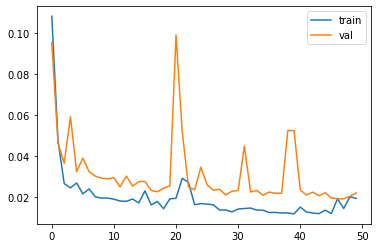

In [13]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

In [14]:
prediction = model.predict(np.array(X_test))
prediction = scaler.inverse_transform(prediction)
prediction=pd.DataFrame(prediction)
prediction

,0,1,2,3,4,5,6,7,8,9,...,1416,1417,1418,1419,1420,1421,1422,1423,1424,1425
0,8.541690,2.375250,4.521226,4.537191,3.184920,0.628688,4.436784,4.453376,3.851404,2.772247,...,0.0,15.373477,0.0,68.394363,63.601685,2.327364,5.983360,33.730659,0.0,24.784576
1,8.215820,2.168982,4.412790,4.394419,3.027982,0.602604,4.061683,4.222139,3.751085,2.555842,...,0.0,14.923941,0.0,66.511513,62.134609,2.622720,5.659585,30.732027,0.0,24.569283
2,8.020019,2.038011,4.332127,4.315902,2.921572,0.586829,3.821975,4.049197,3.705685,2.412299,...,0.0,14.645864,0.0,65.466743,61.261467,2.838447,5.425490,28.881596,0.0,24.463768
3,7.866039,1.940847,4.275412,4.259027,2.850544,0.577045,3.664815,3.911383,3.673800,2.290620,...,0.0,14.426622,0.0,64.763916,60.721943,3.058506,5.210987,27.541958,0.0,24.444277
4,7.699924,1.849083,4.276178,4.194144,2.764172,0.567138,3.486418,3.747348,3.653122,2.138065,...,0.0,14.140239,0.0,63.631245,59.831928,3.443239,4.915341,25.527925,0.0,24.467327
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282,10.130587,3.363322,5.034909,5.218387,3.834666,0.745297,5.839572,5.593102,4.402781,3.855613,...,0.0,17.936625,0.0,77.967003,70.665924,0.419506,7.930959,48.587715,0.0,25.472303
283,9.809618,3.200181,4.921630,5.069911,3.727772,0.721920,5.533820,5.431411,4.280338,3.660749,...,0.0,17.372242,0.0,75.793983,69.226913,0.821100,7.582758,45.722443,0.0,25.294104
284,9.749896,3.179045,4.884156,5.047662,3.705335,0.717873,5.455420,5.433265,4.262151,3.628412,...,0.0,17.288624,0.0,75.433907,69.007622,0.902284,7.539300,45.185837,0.0,25.241762
285,9.618620,3.066751,4.829336,4.994699,3.651852,0.708304,5.382584,5.313488,4.198900,3.524940,...,0.0,17.127604,0.0,74.752335,68.363647,1.021890,7.351371,44.100391,0.0,25.219465


In [15]:
y_test=scaler.inverse_transform(y_test)
y_test=pd.DataFrame(y_test)
y_test

,0,1,2,3,4,5,6,7,8,9,...,1416,1417,1418,1419,1420,1421,1422,1423,1424,1425
0,5.0,2.0,4.0,3.0,1.0,0.0,5.0,7.0,3.0,2.0,...,0.0,17.0,0.0,127.0,86.0,12.0,2.0,69.0,9.0,30.0
1,8.0,2.0,2.0,7.0,8.0,1.0,6.0,5.0,3.0,1.0,...,0.0,11.0,0.0,152.0,83.0,6.0,4.0,91.0,8.0,28.0
2,4.0,2.0,1.0,4.0,1.0,0.0,6.0,3.0,2.0,2.0,...,0.0,14.0,0.0,167.0,88.0,9.0,2.0,67.0,19.0,23.0
3,3.0,2.0,5.0,1.0,6.0,0.0,6.0,7.0,2.0,3.0,...,0.0,16.0,0.0,103.0,97.0,9.0,3.0,90.0,10.0,34.0
4,11.0,3.0,1.0,2.0,5.0,2.0,2.0,4.0,1.0,2.0,...,0.0,18.0,0.0,75.0,79.0,5.0,3.0,39.0,14.0,31.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282,9.0,5.0,6.0,9.0,9.0,4.0,4.0,7.0,4.0,4.0,...,0.0,16.0,0.0,252.0,115.0,13.0,5.0,128.0,20.0,31.0
283,8.0,6.0,7.0,3.0,5.0,3.0,7.0,9.0,3.0,4.0,...,0.0,14.0,0.0,172.0,108.0,14.0,3.0,115.0,12.0,29.0
284,8.0,6.0,7.0,6.0,4.0,1.0,9.0,11.0,2.0,4.0,...,0.0,23.0,0.0,133.0,113.0,21.0,5.0,132.0,24.0,35.0
285,8.0,2.0,3.0,11.0,3.0,2.0,11.0,15.0,6.0,2.0,...,0.0,14.0,0.0,127.0,107.0,14.0,0.0,121.0,16.0,34.0


In [16]:
prediction_s = prediction.iloc[:,0]
y_test_s = y_test.iloc[:,0]
y_train_s=pd.DataFrame(y_train).iloc[:,0]
y_val_s=pd.DataFrame(y_val).iloc[:,0]

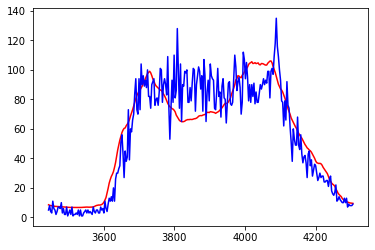

In [17]:
w=3
x1=np.linspace(0,y_train_s.shape[0]*w,y_train_s.shape[0])
x2=np.linspace(y_train_s.shape[0]*w,(y_train_s.shape[0]+y_val_s.shape[0])*w,y_val_s.shape[0])
x3=np.linspace((y_train_s.shape[0]+y_val_s.shape[0])*w,(y_train_s.shape[0]+y_val_s.shape[0]+y_test_s.shape[0])*w,y_test_s.shape[0])
# plt.plot(x1,y_train_s)
# plt.plot(x2,y_val_s)
plt.plot(x3,prediction_s,'r')
plt.plot(x3,y_test_s,'b')
